## RNNLM 모델 생성하기

**모델 구성**

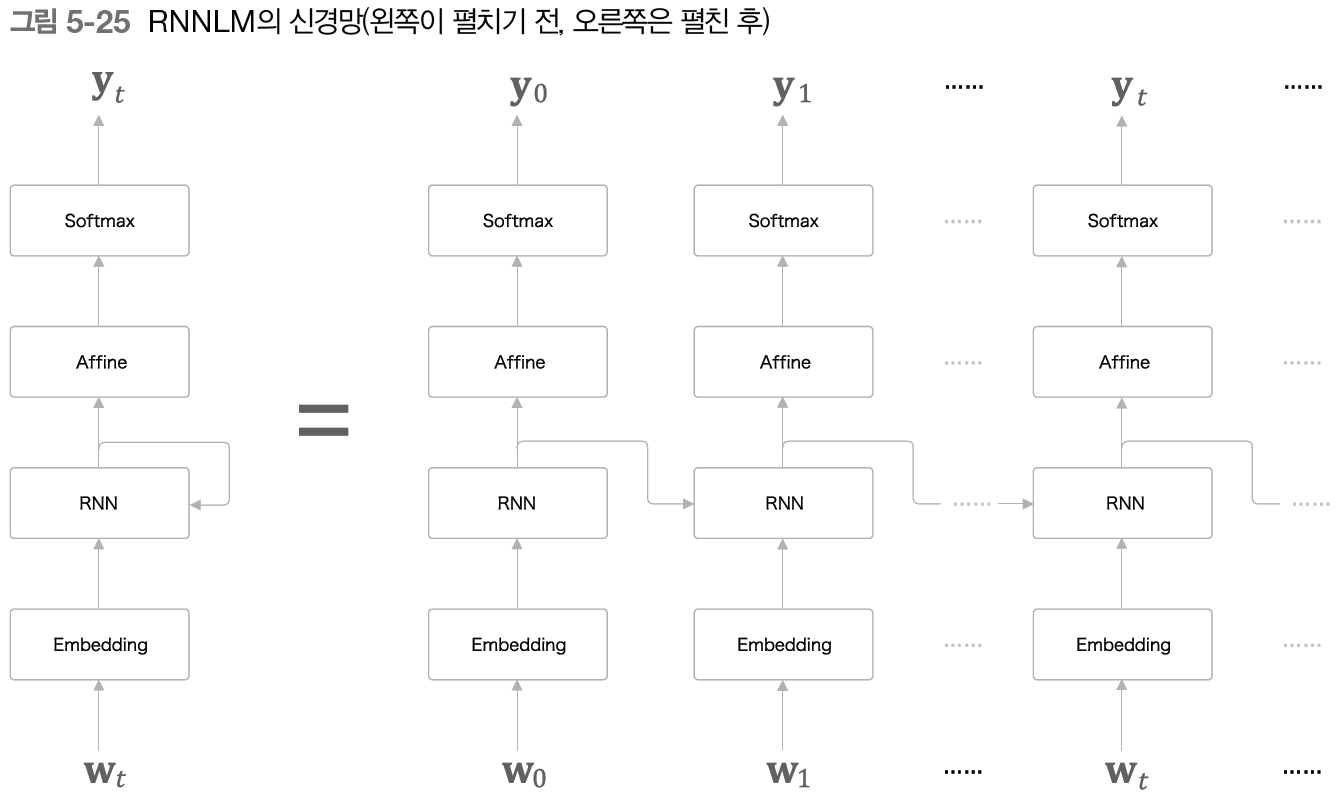

- Embedding 계층에서 자연어를 단어 ID 벡터로 변환하고
- RNN 계층에서 학습을 하여 단어의 분산표현을 출력하고
- Affine 계층에서 학습된 분산표현들을 행렬곱하여
- Softmax 계층에서 정답데이터와 비교하여 손실 및 이후 단어의 출현확률을 생산한다

### Time XX 계층
- 이전의 TimeRNN과 같이 T개의 단어(시점)을 블록 단위로 처리하는 계층구조를 RNNLM에서도 구현하기
- 즉 Embedding, RNN, Affine, Softmax를 모두 Time형식으로 구현하기
- 블록으로 처리하기 위해서 일련의 추가적인 작업 필요

## 코드 구현을 위한 공부
https://www.youtube.com/watch?v=A5sIZJwDf6I&ab_channel=KyungHoonHan

**TimeEmbedding, TimeAffine, TimeSoftmax는 mh_layers에 구현함**   

1) TimeEmbedding
- forward는 N * T * D 형태, 이 때의 값은 Embedding층을 거쳐서 생성된 단어의 초기 분산표현
- backward는 RNN계층으로 부터 받은 데이터

2) TimeAffine
- forward는 N * T * D 형태, 중간 과정에서 (N * T, -1)를 취하는 이유는 행렬곱 계산을 효율적으로 수행하기 위해서 사용. output은 각 단어별 어떤 score
- 아래의 예와 같이 N * T를 취하면 텐서 내부 행렬구조가 유지되면서 열병합된 형태로 구성
- 이를 이용하여 행렬곱 연산을 행렬과 행렬간에 수행할 수 있음
    - 계산량과 복잡성이 큰 텐서 * 행렬 형태의 행렬곱이 아닌
- backward는 Affine 구조와 동일함

3) TimeSoftmaxWithLoss
- forward는 Affine계층을 통과하여 생성된 단어별 score의 손실을 구한 값. 계산 과정에서 affine 계층에서와 동일한 텐서를 행렬 형태로 변환하여 행렬곱 연산을 효율적으로 수행
- backward는 softmax계층이 가장 말미에 위치하므로 dout이 1인 값으로 받아서 수행. output을 affine계층의 output과 형태를 맞추는 것이 중요

In [2]:
# (N*T, -1)확인
import numpy as np

a = np.arange(24).reshape(2, 3, 4)

In [3]:
a

array([[[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11]],

       [[12, 13, 14, 15],
        [16, 17, 18, 19],
        [20, 21, 22, 23]]])

In [5]:
new_a = a.reshape(2*3, -1) 
#tensor의 N * T를 행 size로 취하고 나머지를 열 사이즈로 취하면
#열 차원은 그대로 유지되면서
#기존 텐서의 N배치 사이즈 행렬들이 열병합된 형태로 생성된다

new_a

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11],
       [12, 13, 14, 15],
       [16, 17, 18, 19],
       [20, 21, 22, 23]])

In [6]:
new_a.reshape(2, 3, -1) #다시 본래 행렬 형태로 돌아옴

array([[[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11]],

       [[12, 13, 14, 15],
        [16, 17, 18, 19],
        [20, 21, 22, 23]]])

## SimpleRnnlm 구현

In [13]:
import sys

from mh_common.mh_time_layers import *

class SimpleRnnlm:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        #가중치 초기화
        embed_W = (rn(V, D) / 100).astype('f') 
        rnn_Wx = (rn(D, H) / np.sqrt(D)).astype('f') 
        #이와 같이 이전 노드의 개수에 제곱근을 씌워서 나누어 초기화하는 방식을 'Xavier 초기값'이라고 한다
        rnn_Wh = (rn(H,H) / np.sqrt(H)).astype('f')
        rnn_b = np.zeros(H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        #계층 생성
        self.layers = [
            TimeEmbedding(embed_W),
            TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful = True),
            TimeAffine(affine_W, affine_b)
        ]
        
        self.loss_layer = TimeSoftmaxWithLoss()
        self.rnn_layer = self.layers[1]
        
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
            
    def forward(self, xs, ts):
        for layer in self.layers:
            xs = layer.forward(xs)
        loss  = self.loss_layer.forward(xs, ts)
        return loss
    
    def backward(self, dout = 1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout
    
    def reset_state(self):
        self.rnn_layer.reset_state()

## 언어 모델의 평가

**perplexity, 퍼플렉서티**
- cross entropy loss로 생성되는 손실을 지수의 값으로 치환한 것

### $perplexity = e^{L}$
- perplexity는 값이 작을 수록 좋음. 이는 선택사항의 수로 이해하면 됨. 즉 선택사항이 적을수록 정답이 명확함

말뭉치 크기: 1000, 어휘 수: 418
 | 에폭 1 | 퍼플렉서티 415.29
 | 에폭 2 | 퍼플렉서티 388.72
 | 에폭 3 | 퍼플렉서티 283.30
 | 에폭 4 | 퍼플렉서티 228.63
 | 에폭 5 | 퍼플렉서티 208.44
 | 에폭 6 | 퍼플렉서티 202.40
 | 에폭 7 | 퍼플렉서티 197.15
 | 에폭 8 | 퍼플렉서티 195.20
 | 에폭 9 | 퍼플렉서티 190.32
 | 에폭 10 | 퍼플렉서티 190.50
 | 에폭 11 | 퍼플렉서티 187.35
 | 에폭 12 | 퍼플렉서티 190.18
 | 에폭 13 | 퍼플렉서티 187.44
 | 에폭 14 | 퍼플렉서티 188.94
 | 에폭 15 | 퍼플렉서티 188.56
 | 에폭 16 | 퍼플렉서티 184.84
 | 에폭 17 | 퍼플렉서티 182.16
 | 에폭 18 | 퍼플렉서티 179.17
 | 에폭 19 | 퍼플렉서티 180.84
 | 에폭 20 | 퍼플렉서티 182.71
 | 에폭 21 | 퍼플렉서티 181.26
 | 에폭 22 | 퍼플렉서티 176.65
 | 에폭 23 | 퍼플렉서티 174.37
 | 에폭 24 | 퍼플렉서티 176.45
 | 에폭 25 | 퍼플렉서티 174.42
 | 에폭 26 | 퍼플렉서티 174.58
 | 에폭 27 | 퍼플렉서티 170.05
 | 에폭 28 | 퍼플렉서티 170.67
 | 에폭 29 | 퍼플렉서티 168.22
 | 에폭 30 | 퍼플렉서티 163.79
 | 에폭 31 | 퍼플렉서티 165.96
 | 에폭 32 | 퍼플렉서티 161.91
 | 에폭 33 | 퍼플렉서티 163.64
 | 에폭 34 | 퍼플렉서티 160.66
 | 에폭 35 | 퍼플렉서티 161.34
 | 에폭 36 | 퍼플렉서티 156.25
 | 에폭 37 | 퍼플렉서티 152.82
 | 에폭 38 | 퍼플렉서티 151.57
 | 에폭 39 | 퍼플렉서티 146.90
 | 에폭 40 | 퍼플렉서티 144.96
 | 에폭 41 | 퍼플렉서티 146.65
 

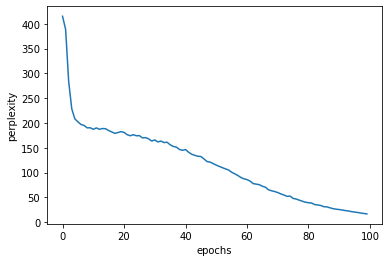

In [14]:
#RNNLM 학습
#노트북 환경이라 직접 실행하지는 않음
from mh_common.mh_optimizer import SGD
sys.path.append(r'C:\Users\kang_lp\OneDrive - UOS\bitamin\dl_nlp_study\deep-learning-from-scratch-2-master')

from dataset import ptb
import matplotlib.pyplot as plt
%matplotlib inline

#하이퍼 파라미터 선언
batch_size = 10
wordvec_size = 100
hidden_size = 100 #RNN 은닉층 크기, RNN벡터 원소 수
time_size = 5
lr = 0.1
max_epoch = 100

#데이터 불러오기
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)

#입력, 정답데이터 생성
xs = corpus[:-1]
ts = corpus[1:] #윈도우 사이즈를 1로 설정한 것과 동일함
data_size = len(xs)
print('말뭉치 크기: %d, 어휘 수: %d' % (corpus_size, vocab_size))

#학습과정중 사용할 iter들 생성
max_iters = data_size // (batch_size * time_size)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

#모델 선언
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)

#미니배치별 시작 위치 계산
jump = (corpus_size -1) // batch_size
offsets = [i* jump for i in range(batch_size)]

for epoch in range(max_epoch):
    for iter in range(max_iters):
        
        batch_x = np.empty((batch_size, time_size), dtype = 'i')
        batch_t = np.empty((batch_size, time_size), dtype = 'i')
        
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size]
                batch_t[i, t] = ts[(offset + time_idx) % data_size]
            time_idx += 1
        
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1
        
    ppl = np.exp(total_loss / loss_count)
    print(' | 에폭 %d | 퍼플렉서티 %.2f' %(epoch+1, ppl))
    ppl_list.append(float(ppl))
    total_loss, loss_count = 0, 0
    
x = np.arange(len(ppl_list))
plt.plot(x, ppl_list, label = 'train')
plt.xlabel('epochs')
plt.ylabel('perplexity')
plt.show()

## RNN 기울기 소실 및 폭발 문제
1) tanh와 기울기 소실
- RNN의 활성화 함수 tanh(x)를 미분하면 $1-y^{2}$, 즉 x가 커질수록tanh의 미분값은 작아지게 됨. 따라서 t시점의 미분값이 초기 시점으로 다다를 수록 기울기가 소실되는 문제 발생   

2) Matmul 계층과 기울기 폭발
- RNN에서 Matmul 계층은 $W_{x}$와  $W_{h}$를 곱하는데 사용됨
- 이때 $W_{h}$의 Matmul 역전파는 dh * $W_{h}^{T}$를 통해서 이뤄지는데, t시점에서 초기 시점까지의 역전파는 $W_{h}^{T}$를 T번 곱하여 이뤄짐
- 즉 기울기가 초기 시점에 다다를 수록 폭발하게 됨

In [1]:
#기울기 폭발 실험
import numpy as np
import matplotlib.pyplot as plt

N = 2
H = 3
T = 20

dh = np.ones((N,H))
np.random.seed(3)
Wh = np.random.randn(H, H)

norm_list = []

for t in range(T):
    dh = np.matmul(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2)) / N
    norm_list.append(norm)

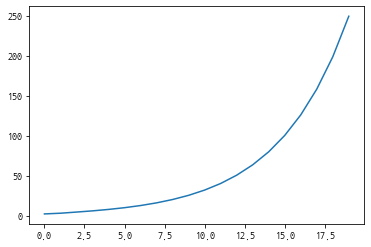

In [3]:
plt.plot(norm_list)

In [4]:
#기울기 소실 실험
N = 2
H = 3
T = 20

dh = np.ones((N,H))
np.random.seed(3)
Wh = np.random.randn(H, H) * 0.5

norm_list = []

for t in range(T):
    dh = np.matmul(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2)) / N
    norm_list.append(norm)

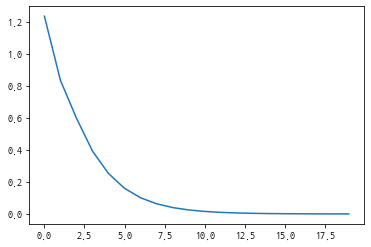

In [5]:
plt.plot(norm_list)

In [ ]:
#기울기 폭발 대책: 기울기 클리핑 gradient clipping

dW1 = np.random.randn(3, 3) * 10
dW2 = np.random.randn(3, 3) * 10
grads = [dW1, dW2]
max_norm = 5.0

def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad**2)
    total_norm = np.sqrt(total_norm)
    
    rate = max_norm / (total_norm + 1e-6)
    if rate <1:
        for grad in grads:
            grad *= rate